# DATA6810 - Assignment 1

## Neural Networks

In this assignment, we are going to practice learning with neural networks using a *regression* example.

**Semester 1, March 2022**

Lecturers and Tutors: Simon Luo and Rafael Oliveira

### Software setup

This code will be run in Python 3, and we need to install a few Python packages. To avoid interference with other
system packages, we basically have two alternatives. We could setup a virtual environment with tools like `virtualenv`
or `anaconda`. Alternatively, we can use online Python interpreters, like Google Colab.

As in the tutorial, you *may* use [Google Colab](https://colab.research.google.com) following the instructions below.

Instructions:
1. Head to Google Colab at: https://colab.research.google.com
2. If you don't have a Google account, you might have to create one.
3. Login with your account
4. At the Welcome screen, select the Upload tab and then upload this notebook file.
5. If you miss the Welcome screen, at the Google Colab notebook view, you can go to:
File -> Upload...
6. After uploading the notebook, upload the data set `rock_properties.csv` file via the "Files" menu at the upper half
of the edge of the Colab screen on the left-hand side. Another option is to upload it using Colab's library. For that,
enter the following in a code cell:
```python
from google.colab import files
uploaded = files.upload()
```
Then run the cell and select the CSV file to upload using the "Choose file" button which will show up under the cell.

You are now all set to run this notebook.

In [24]:
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange

plt.rcParams['figure.facecolor'] = 'white'
%matplotlib inline

In [25]:
# A helper function to train a neural network

def train(model: nn.Module, x: torch.Tensor, y: torch.Tensor,
          n_it=1000, lr=1e-2, weight_decay=0, verbose=True):
    """
    This is a helper function to train a neural network model.

    :param model: PyTorch `nn.Module` neural network model
    :param x: matrix of training points, one per row
    :param y: array of training labels
    :param n_it: number of iterations to run gradient descent for
    :param lr: learning rate
    :param weight_decay: regularisation factor, a small value (e.g. `1e-4`). Default: 0.
    :param verbose: if set to `True` the function will print a progress bar on the screen
    :return: an array recording the loss function values during the training
    """
    loss_fn = nn.MSELoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_losses = torch.zeros(n_it)
    iterator = trange(n_it) if verbose else range(n_it)
    for t in iterator:
        opt.zero_grad()
        loss = loss_fn(model(x), y.view(-1, 1))
        train_losses[t] = loss.detach()
        loss.backward()
        opt.step()
        if verbose:
            iterator.set_postfix(loss=loss.item())
    return train_losses

# Regression problem

We will use a neural network to infer the relationship between the porosity and the density of a rock.


## Rock data

In [26]:
dataset = pd.read_csv("input/rock_properties.csv")

In [27]:
lith_group = dataset['lith_group']

target_group = 'felsic intrusive'
covariate = 'porosity_a'
n_data_dim = 1

response = 'density_db'

data_targets = torch.from_numpy(dataset[lith_group == target_group][response].to_numpy()).float()

data_points = torch.from_numpy(dataset[lith_group == target_group][covariate].to_numpy()).float()
n_data_entries = data_targets.shape[0]


# Shuffle data
data_shuffled_idx = torch.randperm(n_data_entries).numpy()
data_targets = data_targets[data_shuffled_idx]
data_points = data_points[data_shuffled_idx]

# Split training and test sets
train_frac = 0.8
n_train = int(train_frac * n_data_entries)
train_points = data_points[:n_train, None]
train_targets = data_targets[:n_train]
test_points = data_points[n_train:, None]
test_targets = data_targets[n_train:]

Text(0.5, 1.0, 'Training data')

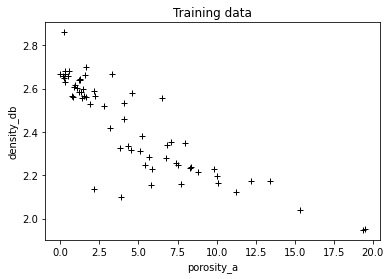

In [28]:
plt.plot(train_points, train_targets, 'k+')
plt.xlabel(covariate)
plt.ylabel(response)
plt.title("Training data")

<b>Problem</b>: Implement and train a neural network model with PyTorch to learn a regression model with the data above.
Feel free to use any combination of layers and activation functions. You are also allowed to use the `train()` function.
After training, test the model on the test data
as given above.

In [29]:
# TODO: Implement your multi-layer perceptron model here.
n_hidden = 10           
n_hidden_layers = 1     
mlp = nn.Sequential(*(  
        [nn.Linear(n_data_dim, n_hidden), nn.ReLU()] 
         + [nn.Linear(n_hidden, n_hidden), nn.ReLU()]*n_hidden_layers   
         +[nn.Linear(n_hidden, 1)]) 
                    )

# TODO: Train your network
losses = train(mlp, train_points, train_targets, lr=1e-3, n_it=4000)

100%|███████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 531.20it/s, loss=0.00981]


In [30]:
def plot_predictions_on_test_set(model: nn.Module):
    # Code to plot the predictions of the model
    with torch.no_grad():
        plt.plot(test_points, mlp(test_points).view(-1), 'b+', label="Predictions")
        plt.plot(test_points, test_targets.view(-1), 'k+', label="True values")
        plt.legend()
        plt.xlabel("Porosity")

In [31]:
def compute_test_loss(model: nn.Module):
    # Code to compute the mean squared-error loss on the test set
    with torch.no_grad():
        loss = (model(test_points).view_as(test_targets) - test_targets).pow(2).mean()
    return loss

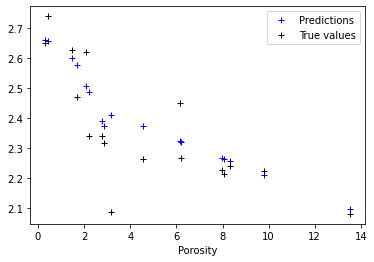

In [32]:
# Plot predicitons
plot_predictions_on_test_set(mlp)

In [33]:
# Compute mean squared error on test set
test_loss = compute_test_loss(mlp)
print(f"Test MSE: {test_loss}")

Test MSE: 0.011739195324480534
